# **Calibration: Fairness in Recommender Systems**

Implementa√ß√£o da disserta√ß√£o ["Explorando Justi√ßa em Sistemas de Recomenda√ß√£o: Calibragem Ponderada, Balanceamentos e M√©tricas"](https://sol.sbc.org.br/index.php/webmedia_estendido/article/view/21975/21798) dos pesquisadores Diego Corr√™a da Silva (diego.correa@ufba.br) e Frederico Ara√∫jo Dur√£o (fdurao@ufba.br).

A disserta√ß√£o busca avaliar algoritmos, m√©tricas e medidas para resolver problemas de precis√£o e injusti√ßa em sistemas de recomenda√ß√£o, por meio da calibragem, e desenvolver um modelo de sistema e um protocolo de decis√£o para recomenda√ß√£o calibradas.

> [C√≥digo original](https://github.com/DiegoCorrea/Exploiting-Personalized-Calibration-and-Metrics-for-Fairness-Recommendation/)



In [ ]:
%pip install scikit-surprise

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 154.4/154.4 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357232 sha256=8f32749cb9bc2f3e1859ae91954e1f46203dbca5059005125319f1c97a5bd317
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
from surprise.model_selection import GridSearchCV
from surprise import Dataset, Reader
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import random

In [ ]:
my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

## **0. Carregamento do dataset**

Como √© comumente √© feito, ser√° utilizado duas bases da dados p√∫blicas: [Movielens 20M](https://grouplens.org/datasets/movielens/) e [One Milion Songs (OMS)](http://millionsongdataset.com/pages/getting-dataset/). Para esta implementa√ß√£o, ser√£o utilizados um subset do primeiro dataset. Al√©m disso, ser√£o definidos algumas constantes para fazer uma rela√ß√£o do c√≥digo para com o artigo.


In [ ]:
TITLE_LABEL = 'title'
GENRE_LABEL = 'genres'
USER_LABEL = 'userId'
ITEM_LABEL = 'itemId'
VALUE_LABEL = 'rating'
CANDIDATES_LIST_SIZE = 100
RECOMMENDATION_LIST_SIZE = 10

In [ ]:
movie_columns = [ITEM_LABEL, TITLE_LABEL, GENRE_LABEL]
ratings_columns = [USER_LABEL, ITEM_LABEL, VALUE_LABEL, "timestamp"]

movies = pd.read_csv("./movies.csv", names=movie_columns, skiprows=1)
ratings = pd.read_csv("./ratings.csv", names=ratings_columns, skiprows=1)

data = movies.merge(ratings, on=ITEM_LABEL)
data.head()

itemId             title                                       genres  \
0       1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1       1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2       1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3       1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4       1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating   timestamp  
0       1     4.0   964982703  
1       5     4.0   847434962  
2       7     4.5  1106635946  
3      15     2.5  1510577970  
4      17     4.5  1305696483

In [ ]:
data.drop(columns=["timestamp"], inplace=True)
for column in [USER_LABEL, ITEM_LABEL]:
    data[column] = data[column].astype("category")
data.head()

itemId             title                                       genres  \
0      1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1      1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2      1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3      1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4      1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

  userId  rating  
0      1     4.0  
1      5     4.0  
2      7     4.5  
3     15     2.5  
4     17     4.5

### **Distribui√ß√£o das notas**

Perceba que segue praticamente uma distribui√ß√£o normal, onde as notas se concentram na m√©dia e poucas notas alcan√ßam o topo como nota 5, at√© menos que a quantidade de filmes que receberam a menor nota. Mostrando que as pessoas tendem a classificar filmes ruins de forma mais f√°cil, ou simplesmente a amostra possui mais filmes ruins.

Text(0.5, 1.0, 'Histograma das notas dos filmes')

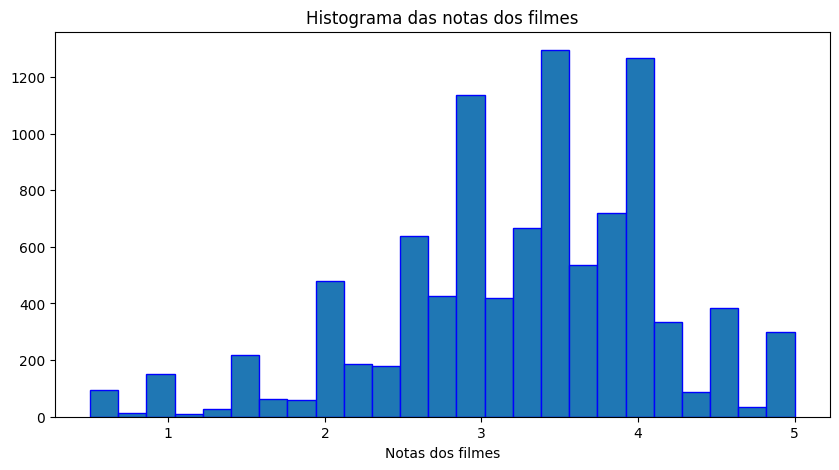

In [ ]:
dftmp = data[[ITEM_LABEL, VALUE_LABEL]].groupby(ITEM_LABEL).mean()
dftmp.hist(bins=25, grid=False, edgecolor='b', label ='Notas', figsize=(10,5))
plt.xlabel('Notas dos filmes')
plt.title('Histograma das notas dos filmes')

### **Distribui√ß√£o por usu√°rio**

Perceba que 95% dos usu√°rios avaliam acima de 2.5, onde os usu√°rios s√£o representados pela curva CDF. Pode ser simplesmente porque os usu√°rios costumam sempre assistir bons filmes, ou apenas se interessam em classificar os bons filmes e n√£o os ruins.

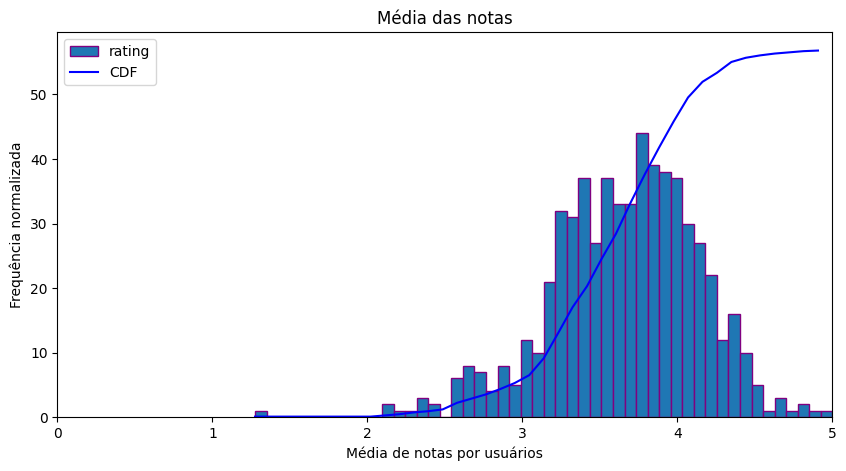

In [ ]:
dftmp = data[[USER_LABEL, VALUE_LABEL]].groupby(USER_LABEL).mean()
dftmp.plot(kind='hist', bins=50, grid=0, edgecolor='purple', figsize=(10,5))

values, base = np.histogram(dftmp, bins=40)
cumulative = np.cumsum(values) * np.diff(base).mean()

plt.plot(base[:-1], cumulative, c='blue', label='CDF')
plt.xlim(0,5)
plt.legend()
plt.xlabel ('M√©dia de notas por usu√°rios')
plt.ylabel ('Frequ√™ncia normalizada')
plt.title ('M√©dia das notas')
plt.show()

### **Filmes por ano**

O n√∫mero de filmes foram crescendo exponencialmente at√© o ano 2000, e passou a diminuir cada vez mais at√© despencar significamente pr√≥ximo de 2020.

In [ ]:
# Extraindo os anos dos filmes
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year
movies.title = movies.title.str[:-7]

movies.head()

itemId                        title  \
0       1                    Toy Story   
1       2                      Jumanji   
2       3             Grumpier Old Men   
3       4            Waiting to Exhale   
4       5  Father of the Bride Part II   

                                        genres    year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995.0  
1                   Adventure|Children|Fantasy  1995.0  
2                               Comedy|Romance  1995.0  
3                         Comedy|Drama|Romance  1995.0  
4                                       Comedy  1995.0

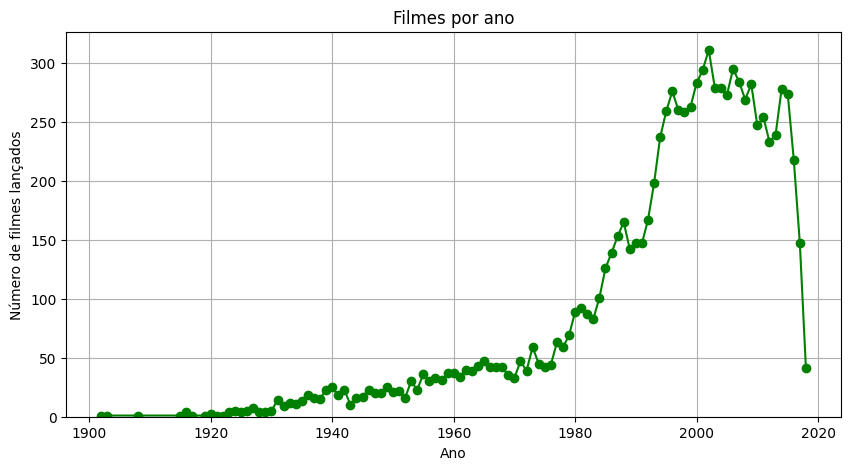

In [ ]:
# Plotando os filmes por ano
dftmp = movies[[ITEM_LABEL, 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.itemId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

ax1.set_xlabel('Ano')
ax1.set_ylabel('N√∫mero de filmes lan√ßados');
plt.title('Filmes por ano')
plt.show()

### **Avalia√ß√µes dos filmes por ano**

Perceba que com o decorrer do tempo, o n√∫mero de avalia√ß√µes negativas come√ßaram a aparecer, coisa que n√£o existia antes. Al√©m disso, as avalia√ß√µes ap√≥s 1980 se concentram entre nota 2 e 4,5.

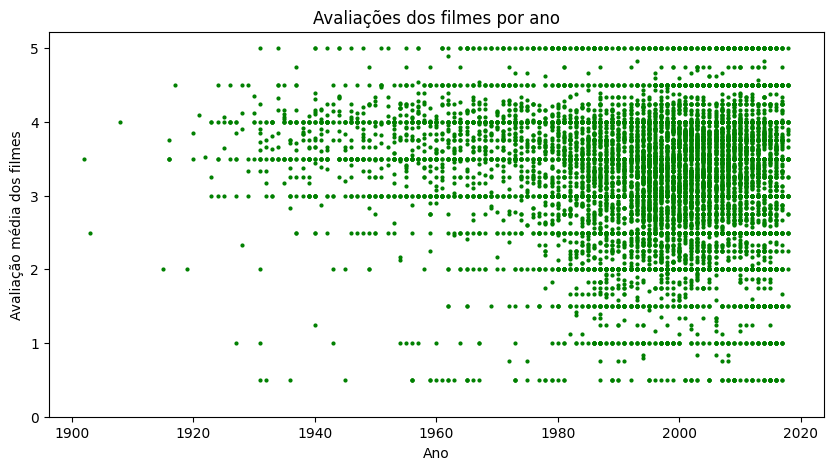

In [ ]:
dftmp = movies[[ITEM_LABEL, 'year']].set_index(ITEM_LABEL).join(
    ratings[[ITEM_LABEL, VALUE_LABEL]].groupby(ITEM_LABEL).mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)
plt.xlabel('Ano')
plt.ylabel('Avalia√ß√£o m√©dia dos filmes')
plt.title('Avalia√ß√µes dos filmes por ano')
plt.ylim(0,)
plt.show()

### **An√°lise dos g√™neros**

Os g√™neros dos filmes foram divididos de forma a analis√°-los individualmente, ent√£o foi selecionado os 5 maiores g√™neros e plotado um gr√°fico de pizza com esse resultado. Perceba que o g√™neros de Drama √© o mais predominante, seguido por com√©dia.

In [ ]:
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

movies.head()

itemId                        title    year  (no genres listed)  Action  \
0       1                    Toy Story  1995.0               False   False   
1       2                      Jumanji  1995.0               False   False   
2       3             Grumpier Old Men  1995.0               False   False   
3       4            Waiting to Exhale  1995.0               False   False   
4       5  Father of the Bride Part II  1995.0               False   False   

   Adventure  Animation  Children  Comedy  Crime  ...  Film-Noir  Horror  \
0       True       True      True    True  False  ...      False   False   
1       True      False      True   False  False  ...      False   False   
2      False      False     False    True  False  ...      False   False   
3      False      False     False    True  False  ...      False   False   
4      False      False     False    True  False  ...      False   False   

    IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller    War  Western  
0  False    False    False    False   False     False  False    False  
1  False    False    False    False   False     False  False    False  
2  False    False    False     True   False     False  False    False  
3  False    False    False     True   False     False  False    False  
4  False    False    False    False   False     False  False    False  

[5 rows x 23 columns]

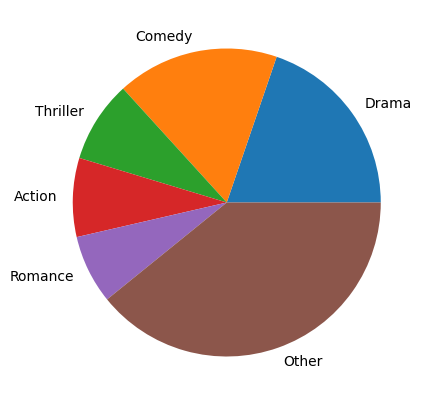

In [ ]:
genre_count = { key: 0 for key in genres_unique["genre"] }
for genre in genre_count:
    count = movies[genre].value_counts()[True]
    genre_count[genre] = count

genre_count = pd.DataFrame.from_dict(genre_count, orient='index')
genre_count.columns = ['count']
genre_count.sort_values(by='count', ascending=False, inplace=True)

genre_count.reset_index(inplace=True)
genre_count.rename(columns={'index': 'genre'}, inplace=True)
other_count = genre_count[5:]["count"].sum()
genre_count = genre_count[:5]
genre_count.loc[5] = ["Other", other_count]

plt.figure(figsize=(10,5))
plt.pie(genre_count['count'], labels=genre_count["genre"])
plt.show()

## **1. Pr√©-processamento**

Esta etapa foca em preprar os dados para o sistema calibrado e √© composta pelas etapas de limpeza, filtragem e modelagem, √© focada em preparar os da-
dos para o sistema. Os datasets ser√£o divididos em 70% dos dados para treinamento e 30% para teste.

In [ ]:
randomized_data = data.sample(frac=1, random_state=my_seed)
threshold = int(0.7 * len(data))

trainset_data = randomized_data[:threshold]
testset_data = randomized_data[threshold:]
len(trainset_data), len(testset_data)

(70585, 30251)

### **1.1. Cria√ß√£o do dataset de treino e teste**

√â utilizado o objeto *Dataset* da biblioteca _Surprise_ para  criar o dataset de treino e teste j√° dividido na etapa anterior. Perceba que para realizar essas etapas ser√£o utilizados apenas o ID do usu√°rio, do item e a avalia√ß√£o.

In [ ]:
def get_testset(data: pd.DataFrame):
    """
    Args:
        data: Dados de teste.

    Returns:
        Dataset de teste.
    """
    reader = Reader()
    testset_ds = Dataset.load_from_df(data, reader)
    testset = testset_ds.build_full_trainset()
    return testset.build_testset()

users_columns = [USER_LABEL, ITEM_LABEL, VALUE_LABEL]
items_columns = [ITEM_LABEL, TITLE_LABEL, GENRE_LABEL]

trainset_df = trainset_data[users_columns]
testset_df = testset_data[users_columns]

reader = Reader()
trainset_ds = Dataset.load_from_df(trainset_df, reader)
trainset = trainset_ds.build_full_trainset()

testset = get_testset(testset_df)

itemset = data[items_columns].drop_duplicates()
itemset.head()

itemId                               title  \
0        1                    Toy Story (1995)   
215      2                      Jumanji (1995)   
325      3             Grumpier Old Men (1995)   
377      4            Waiting to Exhale (1995)   
384      5  Father of the Bride Part II (1995)   

                                          genres  
0    Adventure|Animation|Children|Comedy|Fantasy  
215                   Adventure|Children|Fantasy  
325                               Comedy|Romance  
377                         Comedy|Drama|Romance  
384                                       Comedy

### **1.2. Componente de Distribui√ß√£o dos G√™neros**

Esta etapa visa definir as fun√ß√µes para se obter a **distribui√ß√£o alvo**, baseado nos dados reais do usu√°rio, e a **distribui√ß√£o realizada**, baseado na lista de recomenda√ß√£o resultante dos modelos de recomenda√ß√£o, s√£o utilizadas as fun√ß√µes de extra√ß√£o da distribui√ß√£o p(g|i) e p(g|u).

#### **1.2.1. Fun√ß√£o de identifica√ß√£o da import√¢ncia**

√â definido a fun√ß√£o **p(g|i)**, que identifica o valor da import√¢ncia do g√™nero _g_ no item _i_. Essa fun√ß√£o √© dada pela probabilidade de cada g√™nero para cada √≠tem, ou seja:

$$
p(g|i) = \frac{1}{genresIn(i)}
$$
Onde _g_ √© o g√™nero e _i_ √© o √≠tem, e a fun√ß√£o _genresIn_ est√° obtendo cada g√™nero de _i_.

> Lembrando que o g√™nero para nosso caso √© cada g√™nero de filme e cada √≠tem √© os filmes em si.

In [ ]:
from dataclasses import dataclass

@dataclass
class Item:
    id: int
    title: str
    genres: dict[str, float]
    score: int = 0

def compute_item_dist(dataframe: pd.DataFrame) -> dict[int, Item]:
    """
    Args:
        dataframe: Dados com todos os itens poss√≠veis.

    Returns:
        Dicion√°rio com a probabilidade de cada g√™nero para cada √≠tem.
    """
    item_mapping: dict[int, Item] = dict()
    for row in dataframe.itertuples():
        item_id: int = getattr(row, ITEM_LABEL)
        item_title: str = getattr(row, TITLE_LABEL)
        genre_list: list[str] = getattr(row, GENRE_LABEL).split('|')

        genre_ratio = 1. / len(genre_list)
        item_genre: dict[str, float] = {
            genre: genre_ratio for genre in genre_list
        }

        item = Item(item_id, item_title, item_genre)
        item_mapping[item_id] = item

    return item_mapping

#### **1.2.2. Fun√ß√£o de extra√ß√£o das distribui√ß√µes**

√â otido a **distribui√ß√£o alvo** a partir dos dados reais, com a seguinte f√≥rmula:

$$
p(g|u)=\frac{\sum_{i \in Iu} 1(g \in i) Wu,i \cdot p(g|i)} {\sum_{i \in Iu} 1(g \in i) Wu,i}
$$

Perceba que ele est√° iterando cada item sobre o $Iu$, ou seja os √≠tens do usu√°rio. Ent√£o multiplica cada peso (rating) do item $Wu,i$ pela distribui√ß√£o de itens obtida anteriormente $p(g|i)$. Por fim, divide isso pela soma dos pesos dos itens $\sum_{i} Wu,i$. A fun√ß√£o $1(g \in i)$ faz com que o valor seja 0 caso o g√™nero _g_ n√£o estiver no item _i_.

A fun√ß√£o para se obter a **distribui√ß√£o realizada** √© a mesma, por√©m aplicada sobre a as recomenda√ß√µes:

$$
q(g|u)=\frac{\sum_{i \in CIu} 1(g \in i) Wr(u,i) \cdot p(g|i)} {\sum_{i \in CIu} 1(g \in i) Wr(u,i)}
$$

Perceba que agora ele ir√° iterar cada item pertencente aos itens candidatos para o usu√°rio $CIu$. Al√©m disso, os pesos agoram s√£o sobre a predi√ß√£o dos modelos $Wr(u,i)$.

In [ ]:
from copy import deepcopy

def join_user_to_item_dist(user_df: pd.DataFrame,
                           item_dist: dict[int, Item]) -> dict[int, Item]:
    """
    Args:
        user_df: Dados com os usu√°rios.
        item_dist: Dicion√°rio com a probabilidade de cada g√™nero para cada √≠tem.

    Returns:
        Dicion√°rio que une os usu√°rios com a distribui√ß√£o dos itens.
    """
    user_items: dict[int, Item] = dict()
    for row in user_df.itertuples():
        item_id: int = getattr(row, ITEM_LABEL)
        user_items[item_id] = deepcopy(item_dist[item_id])
        user_items[item_id].score = getattr(row, VALUE_LABEL)
    return user_items

def compute_user_dist(user_items: dict[int, Item]) -> dict[str, float]:
    """
    Soma as pontua√ß√µes ponderadas dos itens do usu√°rio e
    divide pela soma dos pesos dos itens do usu√°rio.

    Args:
        user_items: Dicion√°rio que une os usu√°rios com a distribui√ß√£o dos itens.

    Returns:
        Dicion√°rio com a probabilidade de cada g√™nero para cada usu√°rio.
    """
    user_dist: dict[str, float] = dict()
    weigth_acc: dict[str, float] = dict()
    for item in user_items:
        item_class = user_items[item]
        item_weigth = item_class.score
        for genre, score in item_class.genres.items():
            genre_score = user_dist.get(genre, 0.)
            weigth_rating = weigth_acc.get(genre, 0.)
            weigth_acc[genre] = weigth_rating + item_weigth
            user_dist[genre] = genre_score + (score * item_weigth)

    for genre, genre_score in user_dist.items():
        weigth = genre_score / weigth_acc[genre]
        user_dist[genre] = round(weigth, 3)
    return user_dist

def get_user_distribution(user_df: pd.DataFrame,
                          item_mapping: dict[int, Item]) -> dict[str, float]:
    """
    Args:
        user_df: Dados com os usu√°rios.
        item_mapping: Dicion√°rio com a probabilidade de cada g√™nero para cada √≠tem.

    Returns:
        Dicion√°rio com a probabilidade de cada g√™nero para cada usu√°rio.
    """
    items = join_user_to_item_dist(user_df, item_mapping)
    return compute_user_dist(items)

In [ ]:
item_mapping = compute_item_dist(itemset)

user_dist_list: list[pd.DataFrame] = list()
for user_id in trainset_df[USER_LABEL].unique():
    user_df = trainset_df[trainset_df[USER_LABEL] == user_id]
    user_mapping = join_user_to_item_dist(user_df, item_mapping)
    user_dist = pd.DataFrame(compute_user_dist(user_mapping), index=[user_id])
    user_dist_list.append(user_dist)
user_dist_df = pd.concat(user_dist_list, sort=False).fillna(0.0)
user_dist_df.head()

Action  Mystery  Thriller  Comedy    War  Adventure  Animation  Drama  \
599   0.334    0.316     0.337   0.509  0.351      0.304      0.287  0.492   
282   0.309    0.289     0.314   0.517  0.380      0.287      0.229  0.481   
414   0.324    0.301     0.354   0.513  0.373      0.305      0.263  0.516   
136   0.299    0.337     0.373   0.558  0.318      0.278      0.182  0.506   
58    0.306    0.333     0.386   0.529  0.345      0.301      0.215  0.472   

     Romance  Horror  Sci-Fi  Children  Crime  Film-Noir  Musical  Western  \
599    0.376   0.399   0.332     0.311  0.338      0.287    0.345    0.459   
282    0.373   0.481   0.329     0.225  0.374      0.000    0.305    0.333   
414    0.398   0.381   0.327     0.287  0.350      0.306    0.366    0.520   
136    0.367   0.476   0.317     0.230  0.317      0.000    0.176    0.333   
58     0.379   0.500   0.349     0.245  0.356      0.000    0.259    0.308   

     Documentary   IMAX  Fantasy  (no genres listed)  
599        0.836  0.260    0.296                 1.0  
282        1.000  0.272    0.262                 0.0  
414        0.887  0.251    0.295                 0.0  
136        0.000  0.167    0.279                 0.0  
58         0.000  0.250    0.259                 0.0

## **2. processamento**

Nesta etapa s√£o executados os algoritmos de recomenda√ß√£o. A disserta√ß√£o utiliza 9 algoritmos recomendadores, nem todos ser√£o exibidos neste notebook:
1. **User based K Nearest Neighbors (User-KNN)**
2. **Item based K Nearest Neighbors (Item-KNN)**
3. **Slope One**
4. **Non-negative Matrix Factorization**
5. **Singular Value Decomposition (SVD)**
6. **Singular Value Decomposition Plus Plus (SVD++)**
8. **Co-Clustering**
9. Melhor nota
10. Popularidade

In [ ]:
from surprise import SVD, SVDpp, KNNWithMeans, SlopeOne, NMF, CoClustering

algo_models = {
    "nmf": NMF,
    "svd": SVD,
    "svdpp": SVDpp,
    "slopeone": SlopeOne,
    "user_knn": KNNWithMeans,
    "item_knn": KNNWithMeans,
    "coclustering": CoClustering
}

### **2.1. Defini√ß√£o do espa√ßo de par√¢metros**

Apesar dos autores n√£o utilizarem, eles recomendaram que cada um dos algoritmos fossem otimizados com o _Grid Search_. Para a defini√ß√£o do espa√ßo de hiperpar√¢metros foi utilizado sempre os par√¢metros definidos pela disserta√ß√£o e pelo menos mais algum outro par√¢metro.

In [ ]:
models_params = {
    "svd": {
        "n_epochs": [10, 20],
        "n_factors": [10, 20],
        "lr_all": [0.002, 0.005],
        "reg_all": [0.01, 0.02],
        "random_state": [42]
    },
    "svdpp": {
        "n_epochs": [10, 20],
        "n_factors": [10, 20],
        "lr_all": [0.002, 0.005],
        "reg_all": [0.01, 0.02],
        "random_state": [42]
    },
    "user_knn": {
        "k": [10, 20, 30],
        "min_k": [1, 3],
        "sim_options": {
            'name': ['pearson_baseline'],
            "user_based": [True]
        }
    },
    "item_knn": {
        "k": [10, 20, 30],
        "min_k": [1, 3],
        "sim_options": {
            'name': ['pearson_baseline'],
            "user_based": [False]
        }
    },
    "slopeone": {},
    "coclustering": {
        "n_epochs": [5, 10],
        "n_cltr_u": [3, 5, 10],
        "n_cltr_i": [3, 5, 10],
    },
    "nmf": {
        "biased": [True],
        "n_epochs": [25, 50],
        "random_state": [42],
        "n_factors": [10, 15]
    },
}

### **2.2 Otimiza√ß√£o dos algoritmos**

Esta etapa faz a busca do melhor modelo para cada um dos algoritmos, por fim, √© treinado o modelo com os dados de treinamento. √â utilizado o _trainset_ds_ por uma limita√ß√£o da biblioteca _Surprise_ que exige um objeto _Dataset_ para executar o GridSearchCV.

In [ ]:
models = dict()

for algo, model in tqdm(algo_models.items(), total=len(algo_models)):
    params = models_params[algo]
    grid = GridSearchCV(model, params, cv=5, n_jobs=-1,
                        measures=["rmse"])
    grid.fit(trainset_ds)
    models[algo] = grid.best_estimator["rmse"]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [40:17<00:00, 402.89s/it]


In [ ]:
for algo, model in models.items():
    models[algo] = model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


## **3. p√≥s-processamento**

Esta √© a etapa principal dos sistemas de recomenda√ß√£o. A disserta√ß√£o prop√µe construir aqui um modelo de sistema para recomenda√ß√£o calibrada, composto por alguns componentes.

In [ ]:
def get_user_unknown_items(user_id: int, user_trainset_df: pd.DataFrame,
                           item_mapping: dict[int, Item]) -> pd.DataFrame:
    """
    Args:
        user_id: ID do usu√°rio.
        user_trainset_df: Dados de treinamento do usu√°rio.
        item_mapping: Dicion√°rio com a probabilidade de cada g√™nero para cada √≠tem.

    Returns:
        Dataframe com os itens n√£o avaliados pelo usu√°rio.
    """
    user_items_ids = user_trainset_df[ITEM_LABEL].unique().tolist()
    all_items_ids = item_mapping.keys()
    return pd.DataFrame({
        USER_LABEL: user_id,
        ITEM_LABEL: list(set(all_items_ids) - set(user_items_ids)),
        VALUE_LABEL: 0.0
    })

In [ ]:
from collections import defaultdict

def get_user_pred_df(user_ratings: tuple[int, list[tuple[int, float, float]]],
                     n_items_to_filter: int) -> pd.DataFrame:
    """
    Args:
        user_ratings: Mapeamento de usu√°rios para predi√ß√£o do usu√°rio.
        n_items_to_filter: N√∫mero de itens a serem filtrados.

    Returns:
        Dataframe com as N predi√ß√µes do usu√°rio.
    """
    pred_columns = [USER_LABEL, ITEM_LABEL, VALUE_LABEL, "original_rating"]
    top_n_df = pd.DataFrame()
    uid, ratings = user_ratings
    ratings.sort(key=lambda x: x[1], reverse=True)
    for iid, est, true_r in ratings[:n_items_to_filter]:
        new_row = pd.DataFrame(data=[[uid, iid, est, true_r]],
                               columns=pred_columns)
        top_n_df = pd.concat([top_n_df, new_row])
    return top_n_df

def get_candidates_items(predictions: list[tuple[int, int, float, float, dict]],
                         n=CANDIDATES_LIST_SIZE) -> pd.DataFrame:
    """
    Devolve uma lista de N recomenda√ß√µes a partir da lista de predi√ß√µes.

    Args:
        predictions: Lista de predi√ß√µes dadas por um algoritmo.
        n: N√∫mero de recomenda√ß√µes a serem devolvidas.

    Returns:
        Dataframe com as N recomenda√ß√µes.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))
    map_results_df = [get_user_pred_df(user, n) for user in top_n.items()]
    return pd.concat(map_results_df, sort=False)

In [ ]:
def convert_items_dict_to_df(recommendations: dict[int, Item]) -> pd.DataFrame:
    """
    Converte um dicion√°rio de itens para um dataframe.

    Args:
        recommendations: Dicion√°rio de itens

    Returns:
        Dataframe com os itens
    """
    results_df = pd.DataFrame()
    user_results: list[pd.DataFrame] = list()
    for order, (item_id, item) in enumerate(recommendations.items()):
        user_results += [pd.DataFrame(data=[[item_id, item.score, order]],
                                      columns=[ITEM_LABEL, VALUE_LABEL, "order"])]
    return pd.concat(user_results, sort=False)

### **3.1. Componente de Medida de Justi√ßa**

Esta etapa calcula a medida de diverg√™ncia, que √© a dist√¢ncia entre a distribui√ß√£o realizada e a distribui√ß√£o alvo. A disserta√ß√£o testa as seguintes medidas de diverg√™ncia, no qual as duas √∫ltimas s√£o propostas da disserta√ß√£o, por√©m s√≥ ser√° utilizada a √∫ltima, uma vez que demonstrou melhor desempenho:
1. Kullback-Leibler: Uma diverg√™ncia de Kullback-Leibler igual a 0 indica que as fun√ß√µe/distribui√ß√µes P e Q s√£o muito parecidas (iguais, at√©), enquanto uma diverg√™ncia de 1 indica que se comportam de maneira diferente. Queremos que a diverg√™ncia entre a distribui√ß√£o alvo e distribui√ß√£o realizada seja a menor poss√≠vel.
2. Hellinger: Seguindo a mesma l√≥gica, o valor da dist√¢ncia de Hellinger indica o qu√£o diferentes as duas distribui√ß√µes s√£o. Quanto menor o valor, mais pr√≥ximas est√£o as distribui√ß√µes.
3. **Pearson Chi-Square**: Este teste √© usado para comparar duas distribui√ß√µes de frequ√™ncia e verificar se s√£o significativamente diferentes, sendo definido por:

$$
PC(p,q) = \sum_{g \in G} \frac{(p(g|u) - q'(g|u))^2}{q'(g|u)}
$$


In [ ]:
import math

def compute_pearson_chi_square(user_genre_dist: pd.Series,
                              user_candidates: dict[str, float],
                              alpha: float=0.01) -> float:
    """
    Calcula o Chi-Square, onde quanto menor, melhor.

    Args:
        user_genre_dist: Probabilidade de cada g√™nero para o usu√°rio
        user_candidates: Mapeamento de valor de cada g√™nero para um √≠tem
        alpha: Peso do balanceamento lambda

    Returns:
        Valor do Chi-Square
    """
    sum_value = 0.
    for genre, p in user_genre_dist.items():
        q = user_candidates.get(genre, 0.)
        til_q = (1 - alpha) * q + alpha * p
        if math.isnan(til_q) or til_q == 0.0:
            temp_value = 0.0
        else:
            temp_value = np.power((p - til_q), 2.0) / til_q # AQUI
        if math.isnan(temp_value):
            temp_value = 0.0
        sum_value += temp_value
    return sum_value

### **3.2. Componente do Peso do Balanceamento**

Normalmente os sistemas de recomenda√ß√£o utilizam um peso constante ùúÜ para balancear a relev√¢ncia do ranque com as medidas de diverg√™ncia. Mas a disserta√ß√£o utiliza duas formula√ß√µes para encontrar o valor ùúÜ de forma personalizada.

#### **3.2.1. Vari√¢ncia (VAR)**

Utiliza a vari√¢ncia para encontrar a dispers√£o dos g√™neros no perfil do usu√°rio. Em termos simples, a vari√¢ncia mede o qu√£o dispersos est√£o os interesses do usu√°rio entre diferentes g√™neros. √â definido por:

$$
mp(u) = \frac{\sum_{g \in G} p(g|u)}{|G|}
$$

$$
var(u)=\frac{\sum_{g \in G} |p(g|u) - mp(u)|^2}{|G|}
$$

$$
\lambda u = 1 - var(u)
$$

In [ ]:
def get_lmbda_by_variance(user_genre_dist: pd.Series) -> float:
    """
    Args:
        user_genre_dist: Probabilidade de cada g√™nero para o usu√°rio

    Returns:
        Valor do lambda
    """
    return 1 - user_genre_dist.var()

#### **3.2.2. Contagem de g√™neros (CGR)**

Conta-se quantos g√™neros o usu√°rio possui e divide-se pelo n√∫mero total de g√™neros no sistema. Isso oferece uma medida de qu√£o diversificado √© o perfil de interesses do usu√°rio em rela√ß√£o ao conjunto total de g√™neros dispon√≠veis.

$$
h(u,g) = \{1, otherwise^{0,ifp(g|u)=0}
$$

$$
\lambda u = \frac{\sum_{g \in G} h(u,g)}{|G|}
$$

In [ ]:
def get_lmbda_by_count_genres(user_genre_dist: pd.Series) -> float:
    """
    Args:
        user_genre_dist: Probabilidade de cada g√™nero para o usu√°rio

    Returns:
        Valor do lambda
    """
    count = 0
    for i, number in user_genre_dist.items():
        if number > 0.0:
            count += 1
    return count / len(user_genre_dist)

### **3.3. Componente de Balanceamento**

A partir de um certo ùúÜ obtido na etapa anterior, ser√° realizado o balanceamento para a calibragem. Nesta etapa tamb√©m s√£o propostas duas abordagens pela disserta√ß√£o. Mas s√≥ iremos implementar a abordagem estado-da-arte (LIN).

A outra abordagem √© a Longar√≠tmica (LOG) que tem o objetivo de considerar os (1) g√™neros, (2) itens e o (3) usu√°rio no balanceamento, √© utilizado o vi√©s, adaptando assim a lista de recomenda√ß√£o de acordo com os itens inseridos na lista de recomenda√ß√£o, ent√£o utiliza a forma logar√≠timica para suavizar a curva e contar com a adi√ß√£o de um vi√©s do usu√°rio.
Exemplificando, pense em uma lista de filmes recomendados. A abordagem logar√≠tmica suaviza o impacto da diverg√™ncia, garantindo que a recomenda√ß√£o seja diversificada sem sacrificar demais a relev√¢ncia dos filmes para o usu√°rio.


#### **3.3.1. Maginal Relevance (MR)**

_Steck_ apresenta um balanceamento linear (LIN) dividida em duas partes, de forma que quanto maior a diverg√™ncia, maior √© a subtra√ß√£o no valor do ranque:

$$
s(CIu)=\sum_{i \in CIu}{Wr(u,i)}
$$

$$
MR(p, CIu)=(1 - Œª) . s(CIu) - Œª.F(p,q(CIu))
$$

Onde $s(CIu)$ √© a soma dos pesos dos itens preditos, a fun√ß√£o que devolve a medida de Fairness $F(p,q)$ √© o _Pearson chi-square_ para o nosso caso e o valor de trade-off Œª √© dado pelo VAR ou CGR, respons√°vel por indicar se o usu√°rio prefere recomenda√ß√µes com maior similaridade $s(CIu)$ ou equidade $F(p,q)$.

Para exemplificar, imagine que voc√™ tem uma lista de m√∫sicas recomendadas. Se ùúÜùë¢ for alto, a f√≥rmula vai diminuir a relev√¢ncia se todas as m√∫sicas forem do mesmo g√™nero, incentivando a inclus√£o de diferentes g√™neros na recomenda√ß√£o.


In [ ]:
def linear_calibration(candidates_mapping: dict[int, Item],
                       user_genre_dist: pd.Series,
                       lmbda: float=0.5) -> float:
    """
    Calcula a medida de calibragem linear.

    Args:
        candidates_mapping: Mapeamento de valor de cada g√™nero para um √≠tem
        user_genre_dist: Probabilidade de cada g√™nero para o usu√°rio
        lmbda: Peso do balanceamento lambda

    Returns:
        Valor da medida de calibragem
    """
    candidates_dist = compute_user_dist(candidates_mapping)
    div_value = compute_pearson_chi_square(user_genre_dist, candidates_dist)

    total_score = 0.0
    for item in candidates_mapping.values():
        total_score += item.score

    return (1 - lmbda) * total_score - lmbda * div_value

### **3.4. Componente do Algoritmo de Sele√ß√£o**

Ser√° utilizado o Surrogate Submodular para  selecionar os itens, como est√° no estado-da-arte. Se trazindo na f√≥rmula de Maximum Marginal Relevance (MMR), dado por:

$$
R^*= arg max MR(p, CIu)
$$

O Surrogate Submodular segue o seguinte algoritmo:

1. $R^*$ come√ßa vazio $\{\}$;
2. Para cada itera√ß√£o dos itens candidatos, se o item _i_ maximiza o $R^*$, ent√£o adicione √† lista.
3. Por fim, a lista ter√° $n-1$ itens e o √∫ltimo item adicionado segue o MMR, completando os top-n itens $R^*$.

In [ ]:
def surrogate_submodular(user_genre_dist: pd.Series,
                         candidates_mapping: dict[int, Item],
                         n: int=RECOMMENDATION_LIST_SIZE, lmbda: float=0.5):
    """
    Inicia com uma lista de recomenda√ß√£o vazia e itera sobre os top N,
    atualizando a lista com os itens que maximizam a medida de calibragem.

    Args:
        user_genre_dist: Probabilidade de cada g√™nero para o usu√°rio
        candidates_mapping: Mapeamento de valor de cada g√™nero para um √≠tem
        n: N√∫mero de itens a serem selecionados
        lmbda: Peso do balanceamento lambda

    Returns:
        Dicion√°rio com os itens selecionados
    """
    selected_items: dict[int, Item] = {}
    for _ in range(n):
        max_utility = -np.inf
        best_item: Item = Item(-1, "", dict())
        best_id: int = -1
        for i_id, item in candidates_mapping.items():
            if i_id in selected_items.keys():
                continue
            temp = deepcopy(selected_items)
            temp[i_id] = item

            utility = linear_calibration(temp, user_genre_dist, lmbda)

            if utility > max_utility:
                max_utility = utility
                best_item = item
                best_id = i_id
        if best_id != -1:
            selected_items[best_id] = best_item
    return selected_items

### **3.5. Execu√ß√£o**

In [ ]:
users_len = len(user_dist_df.index)
candidates_per_user: dict[int, dict[str, dict[int, Item]]] = dict()
for index, user_id in tqdm(enumerate(user_dist_df.index), total=users_len):
    user_train_df = trainset_df[trainset_df[USER_LABEL] == user_id]
    user_unknown_items = get_user_unknown_items(user_id, user_train_df,
                                                item_mapping)
    candidates_per_model: dict[str, dict[int, Item]] = dict()
    for algo, model in models.items():
        candidates_pred = model.test(get_testset(user_unknown_items))
        candidates = get_candidates_items(candidates_pred)
        candidates_mapping = join_user_to_item_dist(candidates, item_mapping)

        candidates_per_model[algo] = candidates_mapping
    candidates_per_user[user_id] = candidates_per_model

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 610/610 [40:42<00:00,  4.00s/it]


In [ ]:
weights_variants = [("VAR", get_lmbda_by_variance),
                    ("CGR", get_lmbda_by_count_genres)]

recommendations_by_user = dict()
for user_id, user_genre_dist in tqdm(user_dist_df.iterrows(),
                                     total=users_len):
    recommendations_by_algo = dict()
    for algo, candidates_mapping in candidates_per_user[user_id].items():
        recommendations_by_weight = dict()
        for weight_label, weight_func in weights_variants:
            lmbda = weight_func(user_genre_dist)
            reco_items = surrogate_submodular(user_genre_dist,
                              candidates_mapping, lmbda=lmbda)
            reco_dfs = convert_items_dict_to_df(dict(reco_items))
            reco_dfs.sort_values(by="order", inplace=True)
            recommendations_by_weight[weight_label] = reco_dfs
        recommendations_by_algo[algo] = recommendations_by_weight
    recommendations_by_user[user_id] = recommendations_by_algo

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 610/610 [19:23<00:00,  1.91s/it]


## **4. Protocolo de Decis√£o**

Nesta etapa a disserta√ß√£o prop√µe a cria√ß√£o de um protocolo de decis√£o para recomenda√ß√£o calibrada, composto por duas m√©trica, dois coeficientes e a decis√£o.

In [ ]:
def get_mrr_from_list(relevance_array):
    """
    Args:
        relevance_array: Mapeamento de cada recomenda√ß√£o
        para com o array de teste.

    Returns:
        Valor do MRR
    """
    relevance_list_size = len(relevance_array)
    if relevance_list_size == 0:
        return 0.0

    for i in range(relevance_list_size):
        if relevance_array[i]:
            return 1 / (i + 1)
    return 0.0

def compute_mrr(recommendations: pd.DataFrame,
                test_items_ids: list[int]) -> float:
    """
    Args:
        recommendations: Dataframe com os itens recomendados
        test_items_ids: Lista de itens de teste

    Returns:
        Valor do MRR
    """
    items_array = recommendations[ITEM_LABEL].tolist()
    precision = [x in test_items_ids for x in items_array]
    return get_mrr_from_list(precision)

### **4.1. M√©tricas**

Desconsiderando a m√©trica _Miscalibration_ comumente utilizado, uma vez que n√£o considera a ordem do ranque, a disserta√ß√£o prop√µe duas outras m√©tricas de avalia√ß√£o para o contexto da calibragem:

In [ ]:
def get_ap_from_list(relevance_array: list[bool]) -> float:
    """
    Args:
        relevance_array: Mapeamento de cada recomenda√ß√£o
        para com o array de teste.

    Returns:
        Valor do AP (Average Precision)
    """
    relevance_list_size = len(relevance_array)
    if relevance_list_size == 0:
        return 0.0

    hit_list = list()
    relevant = 0
    for i in range(relevance_list_size):
        if relevance_array[i]:
            relevant += 1
        hit_list.append(relevant / (i + 1))
    ap = sum(hit_list)
    if ap > 0.0:
        return ap / relevance_list_size
    return 0.0


def compute_ap(recommendations: pd.DataFrame,
                test_items_ids: list[int]) -> float:
    """
    Args:
        recommendations: Dataframe com os itens recomendados
        test_items_ids: Lista de itens de teste

    Returns:
        Valor do MAP
    """
    items_array = recommendations[ITEM_LABEL].tolist()
    precision = [x in test_items_ids for x in items_array]
    return get_ap_from_list(precision)

#### **4.1.1. Mean Average Absolute Error (MACE)**

O MACE √© uma m√©trica que ajuda a entender qu√£o bem o sistema de recomenda√ß√£o est√° alinhado com os gostos dos usu√°rios. Ele faz isso medindo a diferen√ßa m√©dia absoluta entre o que √© recomendado e o que os usu√°rios preferem, resumindo isso em um √∫nico valor que representa a precis√£o da calibragem para todos os usu√°rios. √â dado pela f√≥rmula:

$$
CE(u,p,q)=\frac{\sum_{g \in G} |p(g|u) - q(g|u)|}{|G|}
$$

$$
ACE(u)=\frac{\sum_{j=1}^N CE(u,p,q(R^*@j))}{N}
$$

$$
MACE=\frac{\sum_{u \in U} ACE(u)}{|U|}
$$

In [ ]:
def calibration_error(user_genre_dist: pd.Series, reco_dist: dict[str, float]):
    """
    Args:
        user_genre_dist: Probabilidade de cada g√™nero para o usu√°rio
        reco_dist: Probabilidade de cada g√™nero para os itens recomendados

    Returns:
        Valor de CE(u,p,q)
    """
    result = list()
    for k in reco_dist.keys():
        result.append(abs(float(user_genre_dist[k]) - float(reco_dist[k])))

    return sum(result) / len(user_genre_dist)

def compute_ace(user_genre_dist: pd.Series, recommendations: pd.DataFrame,
                item_mapping: dict[int, Item]) -> float:
    """
    Args:
        user_genre_dist: Probabilidade de cada g√™nero para o usu√°rio
        recommendations: Dataframe com os itens recomendados
        item_mapping: Dicion√°rio com a probabilidade de cada g√™nero para cada √≠tem.

    Returns:
        Valor de ACE (average calibration error)
    """
    result = list()
    for k in recommendations["order"].tolist():
        user_dist = get_user_distribution(recommendations[:k], item_mapping)
        result.append(calibration_error(user_genre_dist, user_dist))

    return sum(result) / len(result)

#### **4.1.2. Mean Rank MisCalibration (MRMC)**

Esta m√©trica considera a descalibragem entre as distribui√ß√µes, observando cada posi√ß√£o da lista de recomenda√ß√£o. O c√°lculo √© realizado utilizando a medida de diverg√™ncia implementada pelo sistema. √â dado pela seguinte f√≥rmula:

$$
MC(p,q)=\frac{F(p,q)}{F(pq,q(\{\}))}
$$

$$
RMC(u)=\frac{\sum_{j=1}^N MC(p,q(R^*@j)}{N}
$$

$$
MRMC=\frac{\sum_{u \in U} RMC(u)}{|U|}
$$

In [ ]:
def compute_rmc(user_genre_dist: pd.Series, recommendations: pd.DataFrame,
                item_mapping: dict[int, Item]) -> float:
    """
    Args:
        user_genre_dist: Probabilidade de cada g√™nero para o usu√°rio
        recommendations: Dataframe com os itens recomendados
        item_mapping: Dicion√°rio com a probabilidade de cada g√™nero para cada √≠tem.

    Returns:
        Valor do RMC (rank miscalibration)
    """
    order_list = recommendations["order"].tolist()
    mc_value = 0.0
    for i in order_list:
        reco_distr = get_user_distribution(recommendations[:i], item_mapping)
        norm_dist = get_user_distribution(pd.DataFrame(), item_mapping)

        reco_chi = compute_pearson_chi_square(user_genre_dist, reco_distr)
        norm_chi = compute_pearson_chi_square(user_genre_dist, norm_dist)
        mc_value += reco_chi / norm_chi
    mc_value = mc_value / len(order_list)
    return mc_value

### **4.2. Execu√ß√£o**

In [ ]:
EVALUATION_COLUMNS = ["ALGORITHM", "LAMBDA", "METRIC", "METRIC_VAL"]

results_df = pd.DataFrame(columns=["USER"] + EVALUATION_COLUMNS)
for user_id, user_genre_dist in tqdm(user_dist_df.iterrows(),
                                     total=users_len):
    user_test_df = testset_df[testset_df[USER_LABEL] == user_id]
    test_items_ids = user_test_df[ITEM_LABEL].tolist()

    for algo, algo_reco in recommendations_by_user[user_id].items():
        for lmda_label, weight_recommendations in algo_reco.items():
            ap_value = compute_ap(weight_recommendations, test_items_ids)
            mrr = compute_mrr(weight_recommendations, test_items_ids)
            ace = compute_ace(user_genre_dist, weight_recommendations,
                              item_mapping)
            rmc = compute_rmc(user_genre_dist, weight_recommendations,
                                item_mapping)
            results_df = pd.concat([results_df, pd.DataFrame([
                [user_id, algo, lmda_label, "AP", ap_value],
                [user_id, algo, lmda_label, "MRR", mrr],
                [user_id, algo, lmda_label, "ACE", ace],
                [user_id, algo, lmda_label, "RMC", rmc],
            ], columns=["USER"] + EVALUATION_COLUMNS)])

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 610/610 [02:39<00:00,  3.83it/s]


### **4.3. Decis√£o**

A decis√£o √© dada pela soma de dois coeficientes, onde o menor valor √© considerado o melhor para ser implementado.

1. Coefficient of Calibration Error (CCE):
$\frac{MACE}{MAP}$
2. Coefficient of MisCalibration (CMC): $\frac{MRMC}{MAP}$

At√© ent√£o s√≥ temos o AP (Average Precision), ACE (Average Calibration Error) e RMC (Rank MisCalibration) para cada usu√°rio, ent√£o iremos tirar a m√©dia de cada um desses para obter o MAP, ACE e MRMC.

In [ ]:
best_algo = None
best_value = float('inf')

agg_result = results_df.groupby(["ALGORITHM", "LAMBDA", "METRIC"])["METRIC_VAL"].mean()
for (algorithm, lmbda), group in agg_result.groupby(["ALGORITHM", "LAMBDA"]):
    map_val = group[(algorithm, lmbda, 'AP')]
    cce = group[(algorithm, lmbda, 'ACE')] / map_val
    cmc = group[(algorithm, lmbda, 'RMC')] / map_val

    # Soma CCE e CMC
    sum_value = cce + cmc

    print(f"{algorithm} {lmbda}: {sum_value}")
    # Atualiza o melhor algoritmo se a soma for menor
    if sum_value < best_value:
        best_value = sum_value
        best_algo = (algorithm, lmbda)

print(f"\nO melhor algoritmo √© {best_algo} com valor {best_value}")

item_knn CGR: 148.26478221464154
item_knn VAR: 148.26478221464154
nmf CGR: 24.299303407607077
nmf VAR: 24.5619814639997
slopeone CGR: 57.779156217247035
slopeone VAR: 57.76710657153447
svd CGR: 5.1234366555020685
svd VAR: 5.045594419199135
svdpp CGR: 5.616183660188073
svdpp VAR: 5.635190426738161
user_knn CGR: 14.782814340940053
user_knn VAR: 14.155667863988509

O melhor algoritmo √© ('svd', 'VAR') com valor 5.045594419199135
